In [1]:
import os
import glob
from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

In [2]:
def load_model_data(_type: str) -> Tuple[pd.Index, torch.tensor, torch.tensor]:
    """Retrieve features and outcomes from the proper directory so we can
    feed them into a PyTorch model.
    
    Parameters:
        _type: Choose from 'train', 'dev', or 'test'
        
    Returns:
        A 3-tuple consisting of
            1) A pd.Index so we can associate the outcomes predicted
            by our model to a particular gameid/teamid
            
            2) A 2D torch.tensor of player/team features normalized by column
            
            3) A 1D torch.tensor that represents the points scored by a team
            in a particular game.
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
    
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-data.csv')
    for fp in glob.glob(data_path):
        season = pd.read_csv(fp)
        # Convert string tuples to actual tuples
        season = season.rename(columns=lambda x: eval(x))
        season = season.set_index([('GAME_ID', '', ''), ('TEAM_ID', '', '')])
        df = df.append(season)
    
    outcome_col = ('TEAM_PTS', '', '')
    features = df[df.columns.difference([outcome_col])]
    # Normalize features
    features = (features - features.mean()) / features.std()
    # Need to keep this a DataFrame so our dimensions work in PyTorch
    scores = df[[outcome_col]]
    
    n_features = len(features.columns)
    n_output = len(scores.columns)
    msg = 'Uh oh, you might be losing features!'
    assert n_features + n_output == len(df.columns), msg
    
    features = torch.from_numpy(features.to_numpy(dtype='float32'))
    scores = torch.from_numpy(scores.to_numpy(dtype='float32'))
    
    simple_index = df.index.rename(['GAME_ID', 'TEAM_ID'])
    return simple_index, features, scores

In [3]:
def load_odds_data(_type: str) -> pd.DataFrame:
    """Load the odds DataFrame for a certain domain.
    
    Parameters:
        _type: Choose from 'train', 'dev', or 'test'
        
    Returns:
        A pd.DataFrame indexed by (GAME_ID, TEAM_ID)
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
        
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-odds.csv')
    for fp in glob.glob(data_path):
        season_df = pd.read_csv(fp, index_col=[0, 1])
        df = df.append(season_df)
        
    df = df.reset_index()
    df = df.set_index(['GAME_ID', 'TEAM_ID'])
    return df

In [4]:
def log_two_layers(n: int) -> List[Union[nn.Linear, nn.ReLU]]:
    """Given an input with n features, construct a series
    of neural network layers that decrease logarithmically.
    """
    shift_bit_length = lambda x: 1 << (x - 1).bit_length() - 1
    
    layers = []
    while n > 4:
        power_of_two = shift_bit_length(n)
        # I belive nn.Linear uses Xavier initialization
        layers.append( nn.Linear(n, power_of_two) )
        layers.append( nn.ReLU() )
        n = power_of_two
    # Now n == 4 and we add a final regression layer
    layers.append( nn.Linear(n, 1) )
    return layers

## Main Model Logic/Driver

In [5]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 500
batch_size = 100
learning_rate = 0.0001

# Load data as torch.tensors
_, x_train, y_train = load_model_data('train')
_, x_validate, y_validate = load_model_data('dev')

# Define our model layers by decreasing powers of two
model = nn.Sequential( *log_two_layers(x_train.shape[1]) )
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

validate_ds = TensorDataset(x_validate, y_validate)
validate_dl = DataLoader(validate_ds, batch_size=batch_size * 2)

# L1 loss is more robust to outliers
loss_func = F.l1_loss
# loss_func = F.mse_loss

avg_validation_losses = []
for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        epoch_loss = sum(loss_func(model(xb), yb) for xb, yb in validate_dl)
        avg_validation_losses.append( epoch_loss / len(validate_dl) )

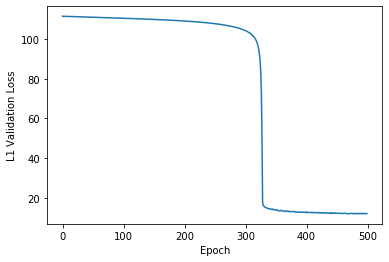

In [6]:
plt.xlabel('Epoch')
plt.ylabel('L1 Validation Loss')
plt.plot(avg_validation_losses)
plt.show()

In [7]:
i_t, x_test, y_test = load_model_data('test')

y_predicted = model(x_test)
# pd.Series are way easier to handle than tensors
y_hat = pd.Series(y_predicted.detach().squeeze(), index=i_t)
y = pd.Series(y_test.detach().squeeze(), index=i_t)

odds = load_odds_data('test').dropna()
intersection = odds.index.intersection(i_t)

# Filter games, since our prepared NBA data doesn't contain
# every game in the season.
odds = odds.loc[intersection]
y_hat = y_hat.loc[intersection]
y = y.loc[intersection]
# Check that both data sources agree on the points scored
assert (y == odds['pts']).all()
assert len(odds) == len(y) == len(y_hat)

In [18]:
wins = pd.DataFrame(index=['ou', 'spread'], columns=['open', 'close'])

# First let's compute the over/unders by group and sum
actual_totals = y.groupby(level='GAME_ID').sum()
model_totals = y_hat.groupby(level='GAME_ID').sum().round()

# Now let's look at spreads
# dropna here means we're comparing the second teams always
actual_spreads = y.groupby(level='GAME_ID').diff().dropna()
model_spreads = y_hat.groupby(level='GAME_ID').diff().dropna().round()

for kind in ('open', 'close'):
    # We generously count a push as a win
    bookie = odds.groupby(level='GAME_ID')[f'ou_{kind}'].first()
    long = (model_totals < bookie) & (actual_totals <= bookie)
    short = (model_totals > bookie) & (actual_totals >= bookie)
    push = model_totals == bookie
    correct_bets = long | short | push
    wins.at['ou', kind] = correct_bets.mean()
    
    # We need to divided be -2 here because the favorite is always given a negative
    # spread, but we actually a positive difference with the opponent
    bookie = odds.groupby(level='GAME_ID')[f'spread_{kind}'].diff().dropna() / -2
    long = (model_spreads > bookie) & (actual_spreads > bookie)
    short = (model_spreads < bookie) & (actual_spreads < bookie)
    push = model_spreads == bookie
    correct_bets = long | short | push
    wins.at['spread', kind] = correct_bets.mean()
    
wins

,open,close
ou,0.483936,0.472892
spread,0.518072,0.5
